# Imports

In [1]:
import gym
import numpy as np
from sklearn.utils import shuffle
import math
import torch
import torch.nn.functional as F
import torch.autograd as autograd 
from torch import nn
from torch import optim
import random
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
from statistics import mean, stdev

env = gym.make('MountainCarContinuous-v0')
#env = gym.wrappers.Monitor(env,"recording")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_dtype(torch.float32)
torch.device(device)
print(device)

cuda


In [2]:
print("Action space:" , env.action_space) 
print("Observation matrix:", env.observation_space)
print("Observation min:",env.observation_space.low)
print("Observation max:", env.observation_space.high)

Action space: Box(-1.0, 1.0, (1,), float32)
Observation matrix: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Observation min: [-1.2  -0.07]
Observation max: [0.6  0.07]


# Functions

In [3]:
class ReLU(nn.Module):
    #Regular Relu except it subtracts by mean
    def forward(self, inp): return (inp.clamp_min(0.) - inp.clamp_min(0.).mean())
    
class Actor(nn.Module): #Uses state and goal and outputs action
    def __init__(self, layers, goal_size = 0):
        
        super(Actor, self).__init__()

        modules = []
        modules.append(nn.Linear(layers[0] + goal_size, layers[1])) #In state size and goal size
        
        for i in range(1,len(layers)-1):
            modules.append(ReLU())
            modules.append(nn.Linear(layers[i], layers[i+1])) #Out num actions
            
        self.model = nn.Sequential(*modules)
        
        self.reset_parameters()
  
    def forward(self,state, goal):
        x = torch.cat([state, goal], dim = -1)
        return self.model(x) #tanh?

    def reset_parameters(self):
        for p in self.model.parameters():
            kaiming = 2/np.sqrt(p.data.size()[0])
            nn.init.uniform_(p.data, -kaiming, kaiming)
            

class Critic(nn.Module): #Uses state, action, goal and outputs Q value
    def __init__(self, layers, action_size = 1, goal_size = 0):

        super(Critic, self).__init__()

        modules = []
        modules.append(nn.Linear(layers[0]+action_size + goal_size, layers[1])) #In states, actions, and goals
        
        for i in range(1,len(layers)-1):
            modules.append(ReLU())
            modules.append(nn.Linear(layers[i], layers[i+1])) #Out Q value
            
        self.model = nn.Sequential(*modules)
        
        self.reset_parameters()
   
    def forward(self, state, action, goal = None):
        if goal is not None: x = torch.cat([state,action,goal], dim = 1)
        else: x = torch.cat([state,action], dim = 1)
            
        return self.model(x)

    def reset_parameters(self):
        for p in self.model.parameters():
            kaiming = 2/np.sqrt(p.data.size()[0])
            nn.init.uniform_(p.data, -kaiming, kaiming)

            
def toTorch(x):
    return torch.tensor(x,dtype = torch.float32, device = device)
    
#Class is useful so that I remember the order of appends using shift+tab
class Memory():
    def __init__(self, maxMemory):
        #Deque is a fifo list with a max length
        self.memory = deque(maxlen = maxMemory)
        
    #Passes in Bellman equation parameters
    def update(self, goal, state, action, reward, next_state, done):
        self.memory.append((goal, state, action, reward, next_state, done))
    
    #Takes a sample of size batch_size from memory
    def sample(self, batch_size):
        #Zip into tuples all states, then all actions, then all rewards, etc
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    
    def __repr__(self):
        return str(self.memory)

class Trainer():
    
    def __init__(self, layers, action_size =1, goal = env.goal_position, lr = 1e-3, loss_func = F.mse_loss, 
                 memory_size = 1e6, discount = 0.99, batch_size = 64,
                 eps_min = 1e-5, eps_max = 1, eps_decay = 1e-3, noise = 0.01, update_freq = 1, her_update = 1):
        
        #Environment
        self.goal = np.array([env.goal_position])
        self.noise = noise

        #Actor
        self.actor = Actor(layers, goal_size = len(self.goal)).to(device)
        self.target_actor = Actor(layers, goal_size = len(self.goal)).to(device)
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)

        #Critic
        self.critic = Critic(layers, action_size = action_size, goal_size = len(self.goal)).to(device)
        self.target_critic = Critic(layers, action_size = action_size, goal_size = len(self.goal)).to(device)      
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr, weight_decay = 0.01)
        
        #Loss
        self.loss_func = loss_func
        
        #Hyperparameters
        self.memory = Memory(int(memory_size))
        self.eps_min = eps_min
        self.eps_max = eps_max
        self.eps_decay = eps_decay
        self.discount = discount
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.her_update = her_update

    def update_model(self):

        #Take a sample from memory with batch size
        goals, states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        goals = toTorch(goals)
        states = toTorch(states)
        actions = toTorch(actions)
        rewards = toTorch(rewards).unsqueeze(1)
        next_states = toTorch(next_states)
        dones = toTorch(dones).unsqueeze(1)
        
        #Critic Update
        next_actions = self.target_actor(next_states, goals)
        next_Qs = self.target_critic(next_states, next_actions, goals)

        bellman = rewards + (1-dones) * self.discount * next_Qs
        expected_Qs = self.critic(states, actions, goals)
        critic_loss = self.loss_func(bellman,expected_Qs) 
        
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()
    
    
        #Actor Update
        actions_pred = self.actor(states, goals)
        actor_loss = -self.critic(states, actions_pred, goals).mean()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()


    def plot(self, rewards):
        clear_output(True)
        fig = plt.figure(figsize=(20,5))
        plt.title(f"Rewards, Batch # {len(rewards)}")
        plt.plot(rewards)
        plt.show()
        return fig
    
    def cycle_lr(self, i): #Cycle LR, applicable?
        cycle = math.floor(1+i/(2*self.stepsize)) #Essentially a full cycle counter, n for n*epoch == stepsize*2
        triangle = abs(i/self.stepsize - 2*cycle+1)
        self.actor_opt.lr = self.lr + (self.max_lr - self.lr)*max(0,1-triangle)
        self.critic_opt.lr = self.lr + (self.max_lr - self.lr)*max(0,1-triangle)
    
    def decay(self):
        self.lr *= self.lr_decay
        self.max_lr *= self.lr_decay
    def run(self, num_episodes, render = False, end_length = 100, end_condition = 0):
            
        low = env.action_space.low[0] 
        high = env.action_space.high[0]
        rewards = []
        max_reward = 0
        best_episode = 0
        iter = 0

        for episode in range(1,num_episodes+1):

            state = env.reset()
            episode_rewards = 0
            done = False

            while not done: #Run until poll falls or env time ends

                #Lets you watch, but trains so much faster if you don't
                if render: env.render()
 
                #Action
                epsilon = self.epsilon_decay(iter)
                
                if random.random() > epsilon:
                    action = self.actor(toTorch(state),toTorch(self.goal))
                    action = [torch.clamp(action + noise, low, high).item()] #Clamp makes sure it's within acceptable range
                else:
                    action = [np.random.uniform(low, high)] #Random action

                #Take step
                next_state, reward, done, info = env.step(action)
                #if reward < 0: reward = 0

                #Update memory
                self.memory.update(self.goal, state, action, reward, next_state, done)
                if iter%self.her_update==0:
                    self.memory.update([state[0]],state, action, 100, next_state, True) #HER implementation

                #Updates the model if you can take a proper batch
                if len(self.memory) > self.batch_size:
                    self.update_model() #SGD w/ return loss

                #Update target model every update_freq steps:
                if iter%self.update_freq == 0: 
                    self.target_actor.load_state_dict(self.actor.state_dict())
                    self.target_critic.load_state_dict(self.critic.state_dict())

                #Updates misc
                state = next_state
                episode_rewards += reward
                iter += 1

            rewards.append(episode_rewards)
            
            if episode_rewards > max_reward:
                max_reward = episode_rewards
                best_episode = episode

            self.plot(rewards)
            print(epsilon, max_reward)

            #End condition
            if len(rewards)>end_length:
                average = mean(rewards[-end_length:])
                print(average)
                if average > end_condition:
                    env.close()
                    print(f"Finished in {episode} episodes!")
                    return episode
    
    def epsilon_decay(self, step):
        return self.eps_min + (self.eps_max - self.eps_min) * math.exp(-1. * step * self.eps_decay)

# Run

In [4]:
m = env.observation_space.shape[0]
n = 1

layers = [m,64,64,64,n]

batch_size = 128
memory_size = 1e6
discount = 0.99
eps_max = 1
eps_min = 1e-4
eps_decay = 5e-5
update_freq = 1 #How frequently target network gets updated 
lr = 1e-3
noise= 0.01 #Random noise is added to each move
her_update = 2 #Frequency of HER addition to memory

In [5]:
train = Trainer(layers, batch_size = batch_size, discount = discount, eps_max = eps_max, eps_min = eps_min, eps_decay=eps_decay, lr = lr, memory_size = memory_size, noise = noise, update_freq = update_freq, her_update = her_update)

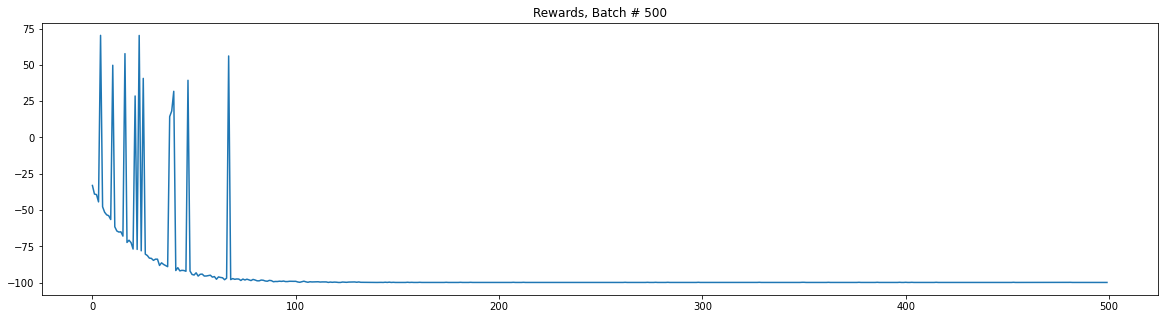

0.00010000001672109526 70.36853444848522
-99.89473778253952


In [6]:
train.run(500, render = False)